In [1]:
import geopandas as gpd

import duckdb


import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
duckdb.sql("INSTALL spatial; LOAD spatial;")


In [5]:
sql = """
WITH src AS (
  SELECT
    tags, tags_before, "user" AS usr,
    changeset, osm_type, osm_id, osm_version,
    valid_from, contrib_type,
    length, length_delta,

    -- ⚙️ Hashtags robust normalisieren: Array → "a b c", String → "a", sonst NULL
    COALESCE(
      array_to_string(try_cast(changeset.tags.hashtags AS VARCHAR[]), ' '),
      try_cast(changeset.tags.hashtags AS VARCHAR)
    ) AS hashtags_text,

    -- Lookups
    tags['highway']          AS hw_after,
    tags['bicycle']          AS bc_after,
    tags['cycleway']         AS cw_after,
    tags['cycleway:left']    AS cw_left_after,
    tags['cycleway:right']   AS cw_right_after,
    tags['cycleway:both']    AS cw_both_after,
    tags['bicycle_road']     AS br_after,

    tags_before['highway']       AS hw_before,
    tags_before['bicycle']       AS bc_before,
    tags_before['cycleway']      AS cw_before,
    tags_before['cycleway:left'] AS cw_left_before,
    tags_before['cycleway:right']AS cw_right_before,
    tags_before['cycleway:both'] AS cw_both_before,
    tags_before['bicycle_road']  AS br_before
  FROM parquet_scan(
    ['~/ohsome-planet/out-germany_cs_251201/contributions/history/way*-*-history-contribs.parquet',
     '~/ohsome-planet/out-germany_cs_251201/contributions/latest/way*-*-latest-contribs.parquet'],
    union_by_name := true
  )
  WHERE osm_type = 'way'
    AND length IS NOT NULL
),
base AS (
  SELECT
    usr.name AS mapper,
    changeset,
    valid_from,
    length                             AS len_after_m,
    length - COALESCE(length_delta,0)  AS len_before_m,
    COALESCE(length_delta,0)           AS dlen_m,
    hashtags_text,                     -- ✅ übernehmen
    hw_after, bc_after, cw_after, cw_left_after, cw_right_after, cw_both_after, br_after,
    hw_before, bc_before, cw_before, cw_left_before, cw_right_before, cw_both_before, br_before
  FROM src
  WHERE hw_after IS NOT NULL
),
cats AS (
  SELECT
    mapper, len_after_m, len_before_m, dlen_m, hashtags_text,
    CASE
      WHEN hw_after = 'cycleway' THEN 'hw=cycleway'
      WHEN (hw_after='path'    AND bc_after='designated') THEN 'hw=path_bicycle-designated'
      WHEN (hw_after='footway' AND bc_after='yes')        THEN 'hw=footway_bicycle-yes'
      WHEN (hw_after='track'   AND bc_after='designated') THEN 'hw=track_bicycle-designated'
      WHEN br_after='yes'                                   THEN 'hw=bicycle_road'
      WHEN COALESCE(hw_after,'') <> 'cycleway' AND (
           cw_after='track' OR cw_left_after='track' OR cw_right_after='track' OR cw_both_after='track'
      ) THEN 'cw=track'
      WHEN COALESCE(hw_after,'') <> 'cycleway' AND (
           cw_after='lane' OR cw_left_after='lane' OR cw_right_after='lane' OR cw_both_after='lane'
      ) THEN 'cw=lane'
      ELSE NULL
    END AS after_cat,

    CASE
      WHEN hw_before = 'cycleway' THEN 'hw=cycleway'
      WHEN (hw_before='path'    AND bc_before='designated') THEN 'hw=path_bicycle-designated'
      WHEN (hw_before='footway' AND bc_before='yes')        THEN 'hw=footway_bicycle-yes'
      WHEN (hw_before='track'   AND bc_before='designated') THEN 'hw=track_bicycle-designated'
      WHEN br_before='yes'                                   THEN 'hw=bicycle_road'
      WHEN COALESCE(hw_before,'') <> 'cycleway' AND (
           cw_before='track' OR cw_left_before='track' OR cw_right_before='track' OR cw_both_before='track'
      ) THEN 'cw=track'
      WHEN COALESCE(hw_before,'') <> 'cycleway' AND (
           cw_before='lane' OR cw_left_before='lane' OR cw_right_before='lane' OR cw_both_before='lane'
      ) THEN 'cw=lane'
      ELSE NULL
    END AS before_cat,

    (
      COALESCE(cw_after IN ('no','separate'), false) OR
      COALESCE(cw_left_after IN ('no','separate'), false) OR
      COALESCE(cw_right_after IN ('no','separate'), false) OR
      COALESCE(cw_both_after IN ('no','separate'), false)
    ) AS cw_after_bad
  FROM base
),
agg AS (
  SELECT
    mapper,
    SUM(CASE
      WHEN after_cat IS NOT NULL AND before_cat IS NULL THEN len_after_m
      WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat = before_cat THEN GREATEST(dlen_m,0)
      WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat <> before_cat THEN len_after_m
      ELSE 0
    END) AS add_m,

    SUM(CASE
      WHEN after_cat IN ('cw=track','cw=lane') AND NOT cw_after_bad AND before_cat IS NULL THEN len_after_m
      WHEN after_cat IN ('cw=track','cw=lane') AND NOT cw_after_bad AND before_cat IS NOT NULL AND after_cat = before_cat THEN GREATEST(dlen_m,0)
      WHEN after_cat IN ('cw=track','cw=lane') AND NOT cw_after_bad AND before_cat IS NOT NULL AND after_cat <> before_cat THEN len_after_m
      ELSE 0
    END) AS add_m_cw_clean,

    SUM(CASE
      WHEN before_cat IS NOT NULL AND after_cat IS NULL THEN len_before_m
      WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat = before_cat THEN -LEAST(dlen_m,0)
      WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat <> before_cat THEN len_before_m
      ELSE 0
    END) AS del_m
  FROM cats
  GROUP BY mapper
),
edits AS (
  SELECT
    mapper,
    MAX(valid_from)               AS last_edit_at,
    CAST(MAX(valid_from) AS DATE) AS last_edit_date,
    COUNT(*)                      AS edits_total,
    COUNT(DISTINCT changeset)     AS changesets_total,
    -- ✅ Anzahl Changesets mit #maproulette (case-insensitive Suche im normalisierten Text)
    COUNT(DISTINCT CASE
      WHEN LOWER(COALESCE(hashtags_text, '')) LIKE '%#maproulette%' THEN changeset
    END) AS ht_maproulette
  FROM base
  GROUP BY mapper
)
SELECT
  a.mapper,
  ROUND(a.add_m/1000.0, 1)               AS km_added,
  ROUND(a.del_m/1000.0, 1)               AS km_deleted,
  ROUND(a.add_m_cw_clean/1000.0, 1)      AS "km_added_cw-clean",
  e.ht_maproulette,                      -- ✅ neue Spalte
  e.last_edit_at,
  e.last_edit_date,
  e.edits_total,
  e.changesets_total
FROM agg a
JOIN edits e USING (mapper)
ORDER BY a.mapper;



"""
           
#duckdb.sql(sql)

In [6]:
df = duckdb.sql(sql).df()
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,mapper,km_added,km_deleted,km_added_cw-clean,ht_maproulette,last_edit_at,last_edit_date,edits_total,changesets_total
0,,447.5,264.3,2.4,0,2009-04-13 22:33:07+02:00,2009-04-13,16224,871
1,Semper Idem,0.0,0.0,0.0,0,2008-06-08 19:03:55+02:00,2008-06-08,4,1
2,!Kevin,0.0,0.0,0.0,0,2025-07-23 14:40:11+02:00,2025-07-23,2,1
3,!MRGBoss,8.4,1.3,0.8,0,2025-06-30 15:31:30+02:00,2025-06-30,12552,1145
4,!PS - Innovationspark Schaumburg,0.0,0.0,0.0,0,2022-09-07 13:27:34+02:00,2022-09-07,1,1
...,...,...,...,...,...,...,...,...,...
139712,Ʝ℮ɴꜱ ₷ᴄʜᴡᴀʀƶ,3.1,0.9,0.0,0,2025-11-30 10:46:12+01:00,2025-11-30,12252,257
139713,ＵｗＵ,3.7,3.0,0.3,0,2025-04-28 14:41:52+02:00,2025-04-28,699,125
139714,🇨🇿 Roman Horník,4.8,4.3,3.1,0,2025-11-22 14:56:47+01:00,2025-11-22,10753,184
139715,🗺️🧭📍,0.0,0.0,0.0,0,2025-11-15 10:23:43+01:00,2025-11-15,79,34


In [7]:
df[(df.mapper =="bicyclett")]

,mapper,km_added,km_deleted,km_added_cw-clean,ht_maproulette,last_edit_at,last_edit_date,edits_total,changesets_total
79197,bicyclett,872.4,316.2,112.8,461,2025-11-30 13:12:10+01:00,2025-11-30,21644,2931


In [9]:
df[(df.mapper =="bicyclett")]

,mapper,km_added,km_deleted,km_added_cw-clean,ht_maproulette,last_edit_at,last_edit_date,edits_total,changesets_total
78093,bicyclett,638.1,261.4,81.2,333,2025-10-05 16:44:16+02:00,2025-10-05,18987,2599


In [12]:
df=df.drop(columns=['last_edit_at'])

In [8]:
df[(df.edits_total > 10000) & (df.last_edit_date > "2025-01-01")].sort_values(by='km_added_cw-clean', ascending=False)[:40]

,mapper,km_added,km_deleted,km_added_cw-clean,ht_maproulette,last_edit_at,last_edit_date,edits_total,changesets_total
126485,smarties,2841.7,856.5,1928.4,0,2025-11-30 01:13:48+01:00,2025-11-30,132282,10195
128783,sundew,530.3,76.4,445.5,0,2025-12-01 00:02:56+01:00,2025-12-01,81440,6241
37390,Langlaeufer,4271.8,4008.5,410.3,591,2025-11-30 22:40:20+01:00,2025-11-30,386528,19993
49756,OSchlüter,531.4,310.1,385.7,0,2025-09-21 13:00:41+02:00,2025-09-21,34857,3823
20488,Fischkopp0815,702.0,539.3,362.8,1,2025-11-26 13:16:24+01:00,2025-11-26,97388,8983
52184,Peilscheibe,2042.2,1596.2,362.5,0,2025-10-06 18:38:10+02:00,2025-10-06,291955,7966
22673,GPS-Wolf,1623.4,908.0,342.5,0,2025-07-30 16:28:15+02:00,2025-07-30,35591,1654
73556,Zartbitter,2765.5,2581.3,319.9,0,2025-11-28 15:59:55+01:00,2025-11-28,172211,12720
31943,JochenB,1177.2,1025.2,307.3,0,2025-11-25 20:34:25+01:00,2025-11-25,128539,2749
34692,KartoGrapHiti,4546.9,3950.3,286.9,0,2025-11-25 23:40:05+01:00,2025-11-25,361899,18683


In [ ]:
df

In [14]:
sql="""
WITH src AS (
  SELECT
    tags, tags_before, "user" AS usr,
    changeset, osm_type, osm_id, osm_version,
    valid_from, contrib_type,
    length, length_delta,

    -- Hashtags robust normalisieren: Array → "a b c", String → "a", sonst NULL
    COALESCE(
      array_to_string(try_cast(changeset.tags.hashtags AS VARCHAR[]), ' '),
      try_cast(changeset.tags.hashtags AS VARCHAR)
    ) AS hashtags_text,

    -- Lookups
    tags['highway']          AS hw_after,
    tags['bicycle']          AS bc_after,
    tags['cycleway']         AS cw_after,
    tags['cycleway:left']    AS cw_left_after,
    tags['cycleway:right']   AS cw_right_after,
    tags['cycleway:both']    AS cw_both_after,
    tags['bicycle_road']     AS br_after,

    tags_before['highway']       AS hw_before,
    tags_before['bicycle']       AS bc_before,
    tags_before['cycleway']      AS cw_before,
    tags_before['cycleway:left'] AS cw_left_before,
    tags_before['cycleway:right']AS cw_right_before,
    tags_before['cycleway:both'] AS cw_both_before,
    tags_before['bicycle_road']  AS br_before
  FROM parquet_scan(
    ['~/ohsome-planet/out-germany_cs/contributions/history/way*-*-history-contribs.parquet',
     '~/ohsome-planet/out-germany_cs/contributions/latest/way*-*-latest-contribs.parquet'],
    union_by_name := true
  )
  WHERE osm_type = 'way'
    AND length IS NOT NULL
),
base AS (
  SELECT
    usr.name AS mapper,
    changeset,
    valid_from,
    length                             AS len_after_m,
    length - COALESCE(length_delta,0)  AS len_before_m,
    COALESCE(length_delta,0)           AS dlen_m,
    hashtags_text,
    hw_after, bc_after, cw_after, cw_left_after, cw_right_after, cw_both_after, br_after,
    hw_before, bc_before, cw_before, cw_left_before, cw_right_before, cw_both_before, br_before
  FROM src
  WHERE hw_after IS NOT NULL
),
cats AS (
  SELECT
    mapper, len_after_m, len_before_m, dlen_m, hashtags_text,
    CASE
      WHEN hw_after = 'cycleway' THEN 'hw=cycleway'
      WHEN (hw_after='path'    AND bc_after='designated') THEN 'hw=path_bicycle-designated'
      WHEN (hw_after='footway' AND bc_after='yes')        THEN 'hw=footway_bicycle-yes'
      WHEN (hw_after='track'   AND bc_after='designated') THEN 'hw=track_bicycle-designated'
      WHEN br_after='yes'                                   THEN 'hw=bicycle_road'
      WHEN COALESCE(hw_after,'') <> 'cycleway' AND (
           cw_after='track' OR cw_left_after='track' OR cw_right_after='track' OR cw_both_after='track'
      ) THEN 'cw=track'
      WHEN COALESCE(hw_after,'') <> 'cycleway' AND (
           cw_after='lane' OR cw_left_after='lane' OR cw_right_after='lane' OR cw_both_after='lane'
      ) THEN 'cw=lane'
      ELSE NULL
    END AS after_cat,

    CASE
      WHEN hw_before = 'cycleway' THEN 'hw=cycleway'
      WHEN (hw_before='path'    AND bc_before='designated') THEN 'hw=path_bicycle-designated'
      WHEN (hw_before='footway' AND bc_before='yes')        THEN 'hw=footway_bicycle-yes'
      WHEN (hw_before='track'   AND bc_before='designated') THEN 'hw=track_bicycle-designated'
      WHEN br_before='yes'                                   THEN 'hw=bicycle_road'
      WHEN COALESCE(hw_before,'') <> 'cycleway' AND (
           cw_before='track' OR cw_left_before='track' OR cw_right_before='track' OR cw_both_before='track'
      ) THEN 'cw=track'
      WHEN COALESCE(hw_before,'') <> 'cycleway' AND (
           cw_before='lane' OR cw_left_before='lane' OR cw_right_before='lane' OR cw_both_before='lane'
      ) THEN 'cw=lane'
      ELSE NULL
    END AS before_cat,

    (
      COALESCE(cw_after IN ('no','separate'), false) OR
      COALESCE(cw_left_after IN ('no','separate'), false) OR
      COALESCE(cw_right_after IN ('no','separate'), false) OR
      COALESCE(cw_both_after IN ('no','separate'), false)
    ) AS cw_after_bad
  FROM base
),
agg AS (
  SELECT
    mapper,
    SUM(CASE
      WHEN after_cat IS NOT NULL AND before_cat IS NULL THEN len_after_m
      WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat = before_cat THEN GREATEST(dlen_m,0)
      WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat <> before_cat THEN len_after_m
      ELSE 0
    END) AS add_m,

    SUM(CASE
      WHEN after_cat IN ('cw=track','cw=lane') AND NOT cw_after_bad AND before_cat IS NULL THEN len_after_m
      WHEN after_cat IN ('cw=track','cw=lane') AND NOT cw_after_bad AND before_cat IS NOT NULL AND after_cat = before_cat THEN GREATEST(dlen_m,0)
      WHEN after_cat IN ('cw=track','cw=lane') AND NOT cw_after_bad AND before_cat IS NOT NULL AND after_cat <> before_cat THEN len_after_m
      ELSE 0
    END) AS add_m_cw_clean,

    SUM(CASE
      WHEN before_cat IS NOT NULL AND after_cat IS NULL THEN len_before_m
      WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat = before_cat THEN -LEAST(dlen_m,0)
      WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat <> before_cat THEN len_before_m
      ELSE 0
    END) AS del_m
  FROM cats
  GROUP BY mapper
),
edits AS (
  SELECT
    mapper,
    MAX(valid_from)               AS last_edit_at,
    CAST(MAX(valid_from) AS DATE) AS last_edit_date,
    COUNT(*)                      AS edits_total,
    COUNT(DISTINCT changeset)     AS changesets_total,

    -- ✅ Anzahl Changesets mit #maproulette
    COUNT(DISTINCT CASE
      WHEN LOWER(COALESCE(hashtags_text, '')) LIKE '%#maproulette%' THEN changeset
    END) AS ht_maproulette,

    -- ✅ Anzahl Changesets mit #radinfra_de
    COUNT(DISTINCT CASE
      WHEN LOWER(COALESCE(hashtags_text, '')) LIKE '%#radinfra_de%' THEN changeset
    END) AS ht_radinfra_de

  FROM base
  GROUP BY mapper
)
SELECT
  a.mapper,
  ROUND(a.add_m/1000.0, 1)               AS km_added,
  ROUND(a.del_m/1000.0, 1)               AS km_deleted,
  ROUND(a.add_m_cw_clean/1000.0, 1)      AS "km_added_cw-clean",
  e.ht_maproulette,
  e.ht_radinfra_de,
  e.last_edit_at,
  e.last_edit_date,
  e.edits_total,
  e.changesets_total
FROM agg a
JOIN edits e USING (mapper)
ORDER BY a.mapper;
"""

In [15]:
df = duckdb.sql(sql).df()
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,mapper,km_added,km_deleted,km_added_cw-clean,ht_maproulette,ht_radinfra_de,last_edit_at,last_edit_date,edits_total,changesets_total
0,,451.5,264.3,2.4,0,0,2009-04-13 22:33:07+02:00,2009-04-13,16400,878
1,Semper Idem,0.0,0.0,0.0,0,0,2008-06-08 19:03:55+02:00,2008-06-08,4,1
2,!Kevin,0.0,0.0,0.0,0,0,2025-07-23 14:40:11+02:00,2025-07-23,2,1
3,!MRGBoss,8.4,1.3,0.8,0,0,2025-06-30 15:31:30+02:00,2025-06-30,12552,1145
4,!PS - Innovationspark Schaumburg,0.0,0.0,0.0,0,0,2022-09-07 13:27:34+02:00,2022-09-07,1,1
...,...,...,...,...,...,...,...,...,...,...
138110,Ʝ℮ɴꜱ ₷ᴄʜᴡᴀʀƶ,3.1,0.9,0.0,0,0,2025-10-05 02:40:14+02:00,2025-10-05,11970,252
138111,ＵｗＵ,3.7,3.0,0.3,0,0,2025-04-28 14:41:52+02:00,2025-04-28,699,125
138112,🇨🇿 Roman Horník,4.8,4.3,3.1,0,0,2025-07-20 13:40:53+02:00,2025-07-20,10743,183
138113,🗺️🧭📍,0.0,0.0,0.0,0,0,2025-06-09 23:02:41+02:00,2025-06-09,75,31


In [16]:
df[(df.mapper =="bicyclett")]

,mapper,km_added,km_deleted,km_added_cw-clean,ht_maproulette,ht_radinfra_de,last_edit_at,last_edit_date,edits_total,changesets_total
78093,bicyclett,638.1,261.4,81.2,333,160,2025-10-05 16:44:16+02:00,2025-10-05,18987,2599


In [17]:
df=df.drop(columns=['last_edit_at'])

In [18]:
df[(df.edits_total > 10000) & (df.last_edit_date > "2025-01-01")].sort_values(by='km_added_cw-clean', ascending=False)[:40]

,mapper,km_added,km_deleted,km_added_cw-clean,ht_maproulette,ht_radinfra_de,last_edit_date,edits_total,changesets_total
125003,smarties,2840.0,854.6,1927.9,0,0,2025-09-10,132102,10166
127288,sundew,530.3,76.4,445.5,0,0,2025-10-05,80943,6134
36877,Langlaeufer,4202.5,3938.0,405.9,991,33,2025-10-04,368190,18945
49061,OSchlüter,531.4,310.1,385.7,0,0,2025-09-21,34857,3823
51444,Peilscheibe,2042.2,1596.2,362.5,0,0,2025-08-15,291954,7965
20203,Fischkopp0815,700.6,537.8,361.8,332,0,2025-10-05,89116,8809
22362,GPS-Wolf,1623.4,908.0,342.5,0,0,2025-07-30,35591,1654
72506,Zartbitter,2765.4,2581.3,319.8,0,0,2025-10-04,171797,12693
31502,JochenB,1176.6,1024.9,307.3,0,0,2025-10-01,128370,2741
34207,KartoGrapHiti,4545.5,3947.8,286.9,0,0,2025-10-05,361261,18627


In [23]:
#df[(df.edits_total > 10000) & (df.last_edit_date > "2025-01-01") & (df["km_added_cw-clean"] > 30)].sort_values(by=['ht_radinfra_de','ht_maproulette'], ascending=False)[:40]
df[(df.edits_total > 10000) & (df.last_edit_date > "2025-01-01") ].sort_values(by=['ht_radinfra_de','ht_maproulette'], ascending=False)[:40]

,mapper,km_added,km_deleted,km_added_cw-clean,ht_maproulette,ht_radinfra_de,last_edit_date,edits_total,changesets_total
108751,mcliquid,594.3,487.2,28.2,1349,327,2025-10-05,133831,13765
78093,bicyclett,638.1,261.4,81.2,333,160,2025-10-05,18987,2599
10095,CaptainCarte,49.8,66.4,1.9,1990,156,2025-10-02,56434,7100
115377,osmMM038,75.8,74.2,3.8,31,114,2025-09-23,15824,2035
127835,söm4324,36.0,22.0,2.5,641,43,2025-10-05,30212,5165
21887,FroschForscher,35.5,41.3,1.8,71,41,2025-10-04,20754,2948
36877,Langlaeufer,4202.5,3938.0,405.9,991,33,2025-10-04,368190,18945
115333,osm-user12,176.7,98.5,12.8,53,22,2025-10-05,40220,4676
130583,tordans,77.4,45.7,3.7,37,21,2025-10-05,16606,2423
127628,sw_uwu,20.5,12.7,0.6,39,12,2025-09-27,10209,611


In [ ]:
df.sort_values(by='km_added', ascending=False)[:20]

## most of them are bots or vandalism accounts

,mapper,km_added,km_deleted,last_edit_at,last_edit_date,edits_total,changesets_total
33504,KYtyQuaIihonsT,7706705.3,0.0,2024-06-15 22:05:59+02:00,2024-06-15,433,18
19201,Facetat Eon,6425060.0,0.0,2024-06-14 23:03:21+02:00,2024-06-14,483,20
9967,Call Lsssdri Itets,4074017.0,0.0,2024-06-17 16:03:38+02:00,2024-06-17,472,19
48372,NonpOdaOoical,4069140.5,0.0,2024-06-15 22:06:00+02:00,2024-06-15,462,18
80714,cenELolDsENfate,3714127.7,0.0,2024-06-14 23:03:20+02:00,2024-06-14,435,19
24868,GyGinY Pupilize,3703377.9,0.0,2024-06-17 16:03:50+02:00,2024-06-17,465,19
59644,Shdhdemmil Lmont,1814993.3,0.0,2024-06-17 22:09:49+02:00,2024-06-17,228,10
64483,Teinawer,1435313.3,0.0,2024-06-17 22:09:48+02:00,2024-06-17,236,9
18468,Ewrt1,1109521.9,0.0,2024-06-13 09:14:22+02:00,2024-06-13,45,2
5203,Atrete Blostodi,1062854.2,0.0,2024-06-13 07:17:12+02:00,2024-06-13,273,17


In [37]:
df[(df.edits_total > 10000) & (df.last_edit_date > "2025-01-01")].sort_values(by='km_added', ascending=False)[50:100]

,mapper,km_added,km_deleted,last_edit_at,last_edit_date,edits_total,changesets_total
99389,jmsbert,705.7,603.0,2025-10-05 23:48:53+02:00,2025-10-05,53842,7319
22549,Galbinus,705.5,564.6,2025-10-05 20:38:44+02:00,2025-10-05,194377,14067
20203,Fischkopp0815,700.6,537.8,2025-10-05 11:59:11+02:00,2025-10-05,89116,8809
124843,skyper,696.2,704.1,2025-02-23 14:56:08+01:00,2025-02-23,153322,3184
136535,wwwFrank,690.4,33.7,2025-09-28 10:42:58+02:00,2025-09-28,61551,1969
131416,tvbrene,667.2,447.2,2025-10-05 20:22:16+02:00,2025-10-05,170027,2784
118694,q_un_go,658.7,409.8,2025-10-05 15:52:59+02:00,2025-10-05,405558,27223
106873,map per,655.1,553.0,2025-10-04 08:35:09+02:00,2025-10-04,27035,4309
78093,bicyclett,638.1,261.4,2025-10-05 16:44:16+02:00,2025-10-05,18987,2599
25827,Hans Loderer,630.4,291.6,2025-10-05 06:10:49+02:00,2025-10-05,112834,10849


In [34]:
df[(df.mapper =="bicyclett")]

,mapper,km_added,km_deleted,last_edit_at,last_edit_date,edits_total,changesets_total
78093,bicyclett,638.1,261.4,2025-10-05 16:44:16+02:00,2025-10-05,18987,2599


In [18]:
df.sort_values(by='km_added', ascending=False)[18:50]

,mapper,km_added,km_deleted,last_edit_at,last_edit_date,edits_total,changesets_total
74982,anbr,4657.6,3498.2,2017-09-12 20:55:28+02:00,2017-09-12,250639,4488
34207,KartoGrapHiti,4545.5,3947.8,2025-10-05 13:03:08+02:00,2025-10-05,361261,18627
36877,Langlaeufer,4202.5,3938.0,2025-10-04 10:43:42+02:00,2025-10-04,368190,18945
121537,rrissiek,4087.9,646.9,2025-08-30 14:06:09+02:00,2025-08-30,133772,5987
95441,hermann51,3939.1,2936.0,2021-05-03 14:30:18+02:00,2021-05-03,154014,15175
135189,wermak,3103.9,3240.2,2025-10-05 22:27:57+02:00,2025-10-05,263302,19339
125003,smarties,2840.0,854.6,2025-09-10 23:46:48+02:00,2025-09-10,132102,10166
72506,Zartbitter,2765.4,2581.3,2025-10-04 09:18:15+02:00,2025-10-04,171797,12693
49107,Oberförster,2730.2,1035.7,2013-11-18 13:00:19+01:00,2013-11-18,41680,2442
74061,ajoessen,2687.6,2655.7,2012-04-22 13:35:51+02:00,2012-04-22,50330,2938


In [38]:
sql = """
WITH src AS (
  SELECT
    tags, tags_before, "user" AS usr,
    changeset, osm_type, osm_id, osm_version,
    valid_from, contrib_type,
    length, length_delta,
    -- Lookups
    tags['highway']          AS hw_after,
    tags['bicycle']          AS bc_after,
    tags['cycleway']         AS cw_after,
    tags['cycleway:left']    AS cw_left_after,
    tags['cycleway:right']   AS cw_right_after,
    tags['cycleway:both']    AS cw_both_after,
    tags['bicycle_road']     AS br_after,

    tags_before['highway']       AS hw_before,
    tags_before['bicycle']       AS bc_before,
    tags_before['cycleway']      AS cw_before,
    tags_before['cycleway:left'] AS cw_left_before,
    tags_before['cycleway:right']AS cw_right_before,
    tags_before['cycleway:both'] AS cw_both_before,
    tags_before['bicycle_road']  AS br_before
  FROM parquet_scan(
    ['~/ohsome-planet/out-germany_cs/contributions/history/way*-*-history-contribs.parquet',
     '~/ohsome-planet/out-germany_cs/contributions/latest/way*-*-latest-contribs.parquet'],
    union_by_name := true
  )
  WHERE osm_type = 'way'
    AND length IS NOT NULL
),
base AS (
  SELECT
    usr.name AS mapper,
    changeset,
    valid_from,
    length                             AS len_after_m,
    length - COALESCE(length_delta,0)  AS len_before_m,
    COALESCE(length_delta,0)           AS dlen_m,
    hw_after, bc_after, cw_after, cw_left_after, cw_right_after, cw_both_after, br_after,
    hw_before, bc_before, cw_before, cw_left_before, cw_right_before, cw_both_before, br_before
  FROM src
  WHERE hw_after IS NOT NULL
),
cats AS (
  SELECT
    mapper, len_after_m, len_before_m, dlen_m,
    -- AFTER category (exklusiv)
    CASE
      WHEN hw_after = 'cycleway' THEN 'hw=cycleway'
      WHEN (hw_after='path'    AND bc_after='designated') THEN 'hw=path_bicycle-designated'
      WHEN (hw_after='footway' AND bc_after='yes')        THEN 'hw=footway_bicycle-yes'
      WHEN (hw_after='track'   AND bc_after='designated') THEN 'hw=track_bicycle-designated'
      WHEN br_after='yes'                                   THEN 'hw=bicycle_road'
      WHEN COALESCE(hw_after,'') <> 'cycleway' AND (
           cw_after='track' OR cw_left_after='track' OR cw_right_after='track' OR cw_both_after='track'
      ) THEN 'cw=track'
      WHEN COALESCE(hw_after,'') <> 'cycleway' AND (
           cw_after='lane' OR cw_left_after='lane' OR cw_right_after='lane' OR cw_both_after='lane'
      ) THEN 'cw=lane'
      ELSE NULL
    END AS after_cat,

    -- BEFORE category (exklusiv)
    CASE
      WHEN hw_before = 'cycleway' THEN 'hw=cycleway'
      WHEN (hw_before='path'    AND bc_before='designated') THEN 'hw=path_bicycle-designated'
      WHEN (hw_before='footway' AND bc_before='yes')        THEN 'hw=footway_bicycle-yes'
      WHEN (hw_before='track'   AND bc_before='designated') THEN 'hw=track_bicycle-designated'
      WHEN br_before='yes'                                   THEN 'hw=bicycle_road'
      WHEN COALESCE(hw_before,'') <> 'cycleway' AND (
           cw_before='track' OR cw_left_before='track' OR cw_right_before='track' OR cw_both_before='track'
      ) THEN 'cw=track'
      WHEN COALESCE(hw_before,'') <> 'cycleway' AND (
           cw_before='lane' OR cw_left_before='lane' OR cw_right_before='lane' OR cw_both_before='lane'
      ) THEN 'cw=lane'
      ELSE NULL
    END AS before_cat,

    -- Markiere problematische CW-Tags (no / separate) auf irgendeiner Seite
    (
      COALESCE(cw_after IN ('no','separate'), false) OR
      COALESCE(cw_left_after IN ('no','separate'), false) OR
      COALESCE(cw_right_after IN ('no','separate'), false) OR
      COALESCE(cw_both_after IN ('no','separate'), false)
    ) AS cw_after_bad
  FROM base
),
agg AS (
  SELECT
    mapper,

    -- Standard "added" (unverändert)
    SUM(CASE
      WHEN after_cat IS NOT NULL AND before_cat IS NULL THEN len_after_m
      WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat = before_cat THEN GREATEST(dlen_m,0)
      WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat <> before_cat THEN len_after_m
      ELSE 0
    END) AS add_m,

    -- "Clean" added NUR für CW-Kategorien, OHNE cycleway:* = no/separate
    SUM(CASE
      WHEN after_cat IN ('cw=track','cw=lane') AND NOT cw_after_bad AND before_cat IS NULL THEN len_after_m
      WHEN after_cat IN ('cw=track','cw=lane') AND NOT cw_after_bad AND before_cat IS NOT NULL AND after_cat = before_cat THEN GREATEST(dlen_m,0)
      WHEN after_cat IN ('cw=track','cw=lane') AND NOT cw_after_bad AND before_cat IS NOT NULL AND after_cat <> before_cat THEN len_after_m
      ELSE 0
    END) AS add_m_cw_clean,

    -- Deleted (unverändert)
    SUM(CASE
      WHEN before_cat IS NOT NULL AND after_cat IS NULL THEN len_before_m
      WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat = before_cat THEN -LEAST(dlen_m,0)
      WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat <> before_cat THEN len_before_m
      ELSE 0
    END) AS del_m
  FROM cats
  GROUP BY mapper
),
edits AS (
  SELECT
    mapper,
    MAX(valid_from)               AS last_edit_at,
    CAST(MAX(valid_from) AS DATE) AS last_edit_date,
    COUNT(*)                      AS edits_total,
    COUNT(DISTINCT changeset)     AS changesets_total
  FROM base
  GROUP BY mapper
)
SELECT
  a.mapper,
  ROUND(a.add_m/1000.0, 1)               AS km_added,
  ROUND(a.del_m/1000.0, 1)               AS km_deleted,
  ROUND(a.add_m_cw_clean/1000.0, 1)      AS "km_added_cw-clean",
  e.last_edit_at,
  e.last_edit_date,
  e.edits_total,
  e.changesets_total
FROM agg a
JOIN edits e USING (mapper)
ORDER BY a.mapper;
"""

In [39]:
df = duckdb.sql(sql).df()
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,mapper,km_added,km_deleted,km_added_cw-clean,last_edit_at,last_edit_date,edits_total,changesets_total
0,,451.5,264.3,2.4,2009-04-13 22:33:07+02:00,2009-04-13,16400,878
1,Semper Idem,0.0,0.0,0.0,2008-06-08 19:03:55+02:00,2008-06-08,4,1
2,!Kevin,0.0,0.0,0.0,2025-07-23 14:40:11+02:00,2025-07-23,2,1
3,!MRGBoss,8.4,1.3,0.8,2025-06-30 15:31:30+02:00,2025-06-30,12552,1145
4,!PS - Innovationspark Schaumburg,0.0,0.0,0.0,2022-09-07 13:27:34+02:00,2022-09-07,1,1
...,...,...,...,...,...,...,...,...
138110,Ʝ℮ɴꜱ ₷ᴄʜᴡᴀʀƶ,3.1,0.9,0.0,2025-10-05 02:40:14+02:00,2025-10-05,11970,252
138111,ＵｗＵ,3.7,3.0,0.3,2025-04-28 14:41:52+02:00,2025-04-28,699,125
138112,🇨🇿 Roman Horník,4.8,4.3,3.1,2025-07-20 13:40:53+02:00,2025-07-20,10743,183
138113,🗺️🧭📍,0.0,0.0,0.0,2025-06-09 23:02:41+02:00,2025-06-09,75,31


In [42]:
df[(df.edits_total > 10000) & (df.last_edit_date > "2025-01-01")].sort_values(by='km_added_cw-clean', ascending=False)[50:80]

,mapper,km_added,km_deleted,km_added_cw-clean,last_edit_at,last_edit_date,edits_total,changesets_total
33468,KTim,445.0,335.6,99.6,2025-10-05 12:54:06+02:00,2025-10-05,22618,3368
59829,Sieda,172.4,157.2,96.4,2025-10-06 00:52:24+02:00,2025-10-06,40404,10244
66715,Todeskuh,288.1,200.3,95.9,2025-10-04 21:45:36+02:00,2025-10-04,59456,5410
54801,Raymond,240.6,90.4,94.6,2025-09-17 17:17:48+02:00,2025-09-17,63906,5210
77709,bergaufsee,396.4,318.2,94.0,2025-10-04 19:51:05+02:00,2025-10-04,37698,3775
3616,Andre68,375.4,182.1,93.2,2025-10-02 22:39:26+02:00,2025-10-02,158060,9105
68354,Ulifan,348.3,127.6,91.6,2025-09-07 19:01:01+02:00,2025-09-07,15367,817
40074,M_Kucha,605.8,405.7,91.4,2025-09-16 16:42:56+02:00,2025-09-16,59262,7274
102291,kjon,344.8,245.2,88.5,2025-09-28 22:12:54+02:00,2025-09-28,311644,19310
7338,Bernhard W,599.6,462.6,86.3,2025-09-22 20:38:03+02:00,2025-09-22,272935,31193


In [41]:
df[(df.mapper =="bicyclett")]

,mapper,km_added,km_deleted,km_added_cw-clean,last_edit_at,last_edit_date,edits_total,changesets_total
78093,bicyclett,638.1,261.4,81.2,2025-10-05 16:44:16+02:00,2025-10-05,18987,2599


In [2]:

duckdb.sql("INSTALL spatial; LOAD spatial;")

duckdb.sql("""
CREATE OR REPLACE TABLE tmp_rad1 AS
SELECT
  ST_GeomFromWKB(geometry) AS geom,
  tags,
  changeset,
  user,
           
FROM read_parquet(
  ['~/ohsome-planet/out-germany_cs/contributions/history/way*-*-history-contribs.parquet',
   '~/ohsome-planet/out-germany_cs/contributions/latest/way*-*-latest-contribs.parquet'],
  union_by_name=true
)

""")


# valid_from >= DATE '2025-01-01' AND

# WHERE tags['highway'] = 'cycleway' OR tags['highway'] = 'path'
# AND length_delta > 0
# user.name == 'fmc_9'

# user.name IN ('fmc_6', 'fmc_7', 'fmc_8', 'fmc_9', 'fmc_10')

# changeset.tags.hashtags IN ('#fmc_vorrangnetz') 


rows = duckdb.sql("SELECT ST_AsText(geom) AS wkt, tags, changeset, user FROM tmp_rad1").fetchall()


gdf = gpd.GeoDataFrame.from_records(rows, columns=["wkt", "tags", "changeset", "user"])
gdf["geometry"] = gpd.GeoSeries.from_wkt(gdf["wkt"])
gdf = gdf.set_geometry("geometry", crs="EPSG:4326")
gdf#.head()



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

: 

In [4]:
#gdf[gdf.user.str.contains("Emil1887")]

In [5]:
gdf["changeset_id"] = gdf["changeset"].apply(lambda u: u.get("id") if isinstance(u, dict) else None)
gdf["highway"] = gdf["tags"].apply(lambda u: u.get("highway") if isinstance(u, dict) else None)
gdf["hashtags"] = gdf["changeset"].apply(lambda u: u.get("tags").get("hashtags") if isinstance(u, dict) else None)
gdf["user_name"] = gdf["user"].apply(lambda u: u.get("name") if isinstance(u, dict) else None)


In [6]:
gdf=gdf[gdf.highway.notnull()].copy()

In [7]:
gdf.hashtags.value_counts()

hashtags
#radinfra_de;#missing_oneway                                                          1130
#needs_clarification;#radinfra_de;#maproulette                                         575
#radinfra_de;#needs_clarification;#maproulette                                         464
#radinfra_de;#missing_traffic_sign;#traffic_signs                                      418
#missing_segregated;#traffic_signs;#radinfra_de;#maproulette                           403
#radinfra_de;#missing_segregated;#maproulette                                          387
#radinfra_de;#malformed_traffic_sign;#traffic_signs;#maproulette                       374
#radinfra_de                                                                           357
#radinfra_de;#advisory_or_exclusive;#maproulette                                       322
#missing_access_tag_bicycle_road;#traffic_signs;#radinfra_de;#maproulette              317
#radinfra_de;#unexpected_bicycle_access_on_footway;#maproulette                  

In [ ]:
duckdb.sql("""
CREATE OR REPLACE TABLE tmp3 AS
SELECT
  ST_GeomFromWKB(geometry)          AS geom,
  tags,
  tags_before,                       -- << notwendig für Vorher/Nachher-Vergleich
  "user"                             AS usr,     -- Struct bleibt erhalten, Zugriff: usr.name
  changeset,
  osm_type,
  osm_id,
  osm_version,
  valid_from,
  contrib_type,
  length,                            -- m
  length_delta                       -- m (Netto je Version)
FROM read_parquet(
  ['~/ohsome-planet/out-germany_cs/contributions/history/way*-*-history-contribs.parquet',
   '~/ohsome-planet/out-germany_cs/contributions/latest/way*-*-latest-contribs.parquet'],
  union_by_name = true
)
""")

In [ ]:
duckdb.sql("""WITH base AS (
  SELECT
    usr.name AS mapper,
    tags, tags_before,
    length                               AS len_after_m,
    length - COALESCE(length_delta, 0)   AS len_before_m,
    COALESCE(length_delta, 0)            AS dlen_m
  FROM tmp3
  WHERE osm_type='way'
    AND tags['highway'] IS NOT NULL
    AND length IS NOT NULL
),
cats AS (
  SELECT
    mapper, len_after_m, len_before_m, dlen_m, tags, tags_before,

    -- Exklusive Kategorie NACHHER (Priorität von oben nach unten)
    CASE
      WHEN tags['highway']='cycleway' THEN 'hw=cycleway'
      WHEN (tags['highway']='path'    AND tags['bicycle']='designated') THEN 'hw=path_bicycle-designated'
      WHEN (tags['highway']='footway' AND tags['bicycle']='yes')        THEN 'hw=footway_bicycle-yes'
      WHEN (tags['highway']='track'   AND tags['bicycle']='designated') THEN 'hw=track_bicycle-designated'
      WHEN tags['bicycle_road']='yes'                                   THEN 'hw=bicycle_road'
      WHEN COALESCE(tags['highway'],'') <> 'cycleway' AND (
           tags['cycleway']='track' OR tags['cycleway:left']='track'
        OR tags['cycleway:right']='track' OR tags['cycleway:both']='track'
      ) THEN 'cw=track'
      WHEN COALESCE(tags['highway'],'') <> 'cycleway' AND (
           tags['cycleway']='lane' OR tags['cycleway:left']='lane'
        OR tags['cycleway:right']='lane' OR tags['cycleway:both']='lane'
      ) THEN 'cw=lane'
      ELSE NULL
    END AS after_cat,

    -- Exklusive Kategorie VORHER (gleiche Priorität)
    CASE
      WHEN tags_before['highway']='cycleway' THEN 'hw=cycleway'
      WHEN (tags_before['highway']='path'    AND tags_before['bicycle']='designated') THEN 'hw=path_bicycle-designated'
      WHEN (tags_before['highway']='footway' AND tags_before['bicycle']='yes')        THEN 'hw=footway_bicycle-yes'
      WHEN (tags_before['highway']='track'   AND tags_before['bicycle']='designated') THEN 'hw=track_bicycle-designated'
      WHEN tags_before['bicycle_road']='yes'                                         THEN 'hw=bicycle_road'
      WHEN COALESCE(tags_before['highway'],'') <> 'cycleway' AND (
           tags_before['cycleway']='track' OR tags_before['cycleway:left']='track'
        OR tags_before['cycleway:right']='track' OR tags_before['cycleway:both']='track'
      ) THEN 'cw=track'
      WHEN COALESCE(tags_before['highway'],'') <> 'cycleway' AND (
           tags_before['cycleway']='lane' OR tags_before['cycleway:left']='lane'
        OR tags_before['cycleway:right']='lane' OR tags_before['cycleway:both']='lane'
      ) THEN 'cw=lane'
      ELSE NULL
    END AS before_cat
  FROM base
),
agg AS (
  SELECT
    mapper,
    -- Added
    SUM(
      CASE
        WHEN after_cat IS NOT NULL AND before_cat IS NULL THEN len_after_m                            -- neu entstanden
        WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat = before_cat THEN GREATEST(dlen_m,0)  -- gleich: Verlängerung
        WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat <> before_cat THEN len_after_m         -- Kategorienwechsel: voll hinzu
        ELSE 0
      END
    ) AS add_m,

    -- Deleted
    SUM(
      CASE
        WHEN before_cat IS NOT NULL AND after_cat IS NULL THEN len_before_m                           -- weggefallen
        WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat = before_cat THEN -LEAST(dlen_m,0)    -- gleich: Verkürzung
        WHEN after_cat IS NOT NULL AND before_cat IS NOT NULL AND after_cat <> before_cat THEN len_before_m        -- Kategorienwechsel: voll gelöscht
        ELSE 0
      END
    ) AS del_m
  FROM cats
  GROUP BY mapper
)
SELECT
  mapper,
  ROUND(add_m/1000.0, 1) AS km_added,
  ROUND(del_m/1000.0, 1) AS km_deleted
FROM agg
ORDER BY mapper;
""")

##  Radinfra


In [8]:
gdf.user_name.value_counts()


user_name
mcliquid        1841
bicyclett        727
osmMM038         635
S1eK             459
CaptainCarte     384
                ... 
hr73               1
meygrino           1
rza31              1
nelson5000         1
biker33            1
Name: count, Length: 105, dtype: int64

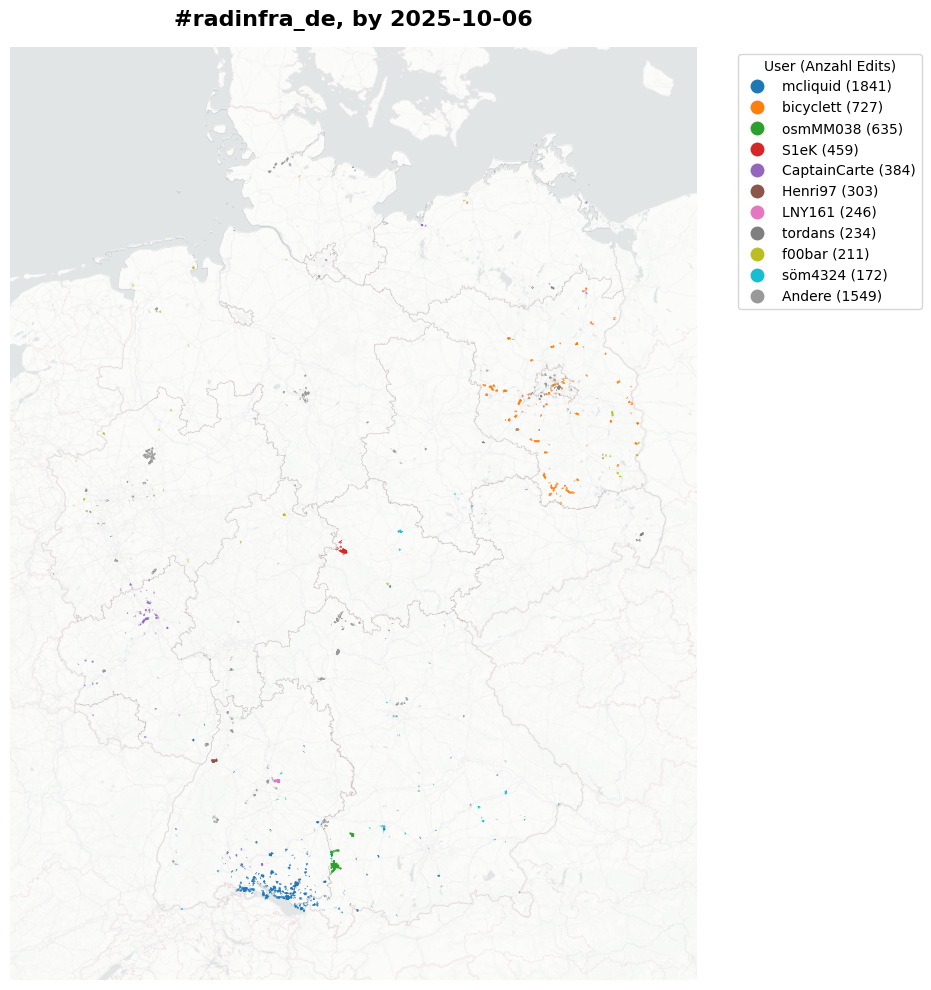

In [9]:
# !pip install contextily  # einmalig, falls noch nicht installiert
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
import contextily as cx

# --- Top-10 + "Andere" wie zuvor ---
top10 = gdf["user_name"].value_counts().head(10)
gdf["user_plot"] = gdf["user_name"].where(gdf["user_name"].isin(top10.index), "Andere")
order = list(top10.index) + ["Andere"]
gdf["user_plot"] = pd.Categorical(gdf["user_plot"], categories=order, ordered=True)

# feste Farbzuordnung in genau dieser Reihenfolge (letzte Farbe neutral/grau für "Andere")
base_cmap = plt.cm.tab20
colors = base_cmap(np.linspace(0, 1, len(order)))
colors[-1] = (0.6, 0.6, 0.6, 1.0)  # "Andere" grau
cmap = ListedColormap(colors)



# Daten laden
shape = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/refs/heads/main/2_bundeslaender/1_sehr_hoch.geo.json")


# --- Reprojektion auf Web-Mercator für die Basemap ---
gdf3857 = gdf.to_crs(epsg=3857)
shape_3857 = shape.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(14, 10))

# 🔹 Shape hinzufügen (kein Legendeneintrag)
shape_3857.boundary.plot(
    ax=ax,
    color="black",       # oder z. B. "black", "darkgrey"
    linewidth=0.03,
    label="_nolegend_" # verhindert Legendeneintrag
)



# 1) Vektordaten plotten (über der Basemap)
gdf3857.plot(
    column="user_plot",
    categorical=True,
    legend=True,
    cmap=cmap,
    ax=ax,
    legend_kwds={
        "bbox_to_anchor": (1.05, 1),
        "loc": "upper left",
        "title": "User (Anzahl Edits)"
    },
    zorder=2
)

# 2) Legendentexte umbenennen (Anzahl in Klammern), Reihenfolge bleibt unverändert
leg = ax.get_legend()
if leg:
    others = int((gdf["user_plot"] == "Andere").sum())
    rename_map = {u: f"{u} ({top10[u]})" for u in top10.index}
    rename_map["Andere"] = f"Andere ({others})"
    for t in leg.get_texts():
        lbl = t.get_text()
        if lbl in rename_map:
            t.set_text(rename_map[lbl])

# 3) Basemap hinzufügen (CartoDB Positron, leicht transparent)
#    Tipp: Für weniger Ablenkung: PositronNoLabels (ohne Beschriftungen)
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.PositronNoLabels,  # oder: CartoDB.Positron
    alpha=0.7,      # Transparenz
    attribution=False
)

# 🔹 Titel hinzufügen
ax.set_title(
    "#radinfra_de, by 2025-10-06",
    fontsize=16,
    fontweight="bold",
    pad=15
)

# Achsen hübsch machen
ax.set_axis_off()
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()


In [10]:
duckdb.sql("""INSTALL spatial; LOAD spatial;

CREATE OR REPLACE TABLE tmp_rad2 AS
SELECT
  ST_GeomFromWKB(geometry)          AS geom,
  tags,
  tags_before,                       -- << notwendig für Vorher/Nachher-Vergleich
  "user"                             AS usr,     -- Struct bleibt erhalten, Zugriff: usr.name
  changeset,
  osm_type,
  osm_id,
  osm_version,
  valid_from,
  contrib_type,
  length,                            -- m
  length_delta                       -- m (Netto je Version)
FROM read_parquet(
  ['~/ohsome-planet/out-germany_cs/contributions/history/way*-*-history-contribs.parquet',
   '~/ohsome-planet/out-germany_cs/contributions/latest/way*-*-latest-contribs.parquet'],
  union_by_name=true
)
WHERE COALESCE(changeset.tags.hashtags,'') ILIKE '%#radinfra_de%';
""")


## WHERE COALESCE(changeset.tags.hashtags,'') ILIKE '%#fmc_vorrangnetz%';


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [11]:
duckdb.sql("""SELECT
  ROUND(SUM(CASE WHEN length_delta > 0 THEN  length_delta ELSE 0 END)/1000.0, 2) AS km_added,
  ROUND(SUM(CASE WHEN length_delta < 0 THEN -length_delta ELSE 0 END)/1000.0, 2) AS km_deleted
FROM tmp_rad2
WHERE osm_type = 'way'
  AND tags['highway'] IS NOT NULL
  AND length_delta IS NOT NULL;
""")

┌──────────┬────────────┐
│ km_added │ km_deleted │
│  double  │   double   │
├──────────┼────────────┤
│    49.93 │      22.34 │
└──────────┴────────────┘

In [12]:
duckdb.sql("""SELECT
  usr.name AS mapper,
  ROUND(SUM(CASE WHEN length_delta > 0 THEN  length_delta ELSE 0 END)/1000.0, 2) AS km_added,
  ROUND(SUM(CASE WHEN length_delta < 0 THEN -length_delta ELSE 0 END)/1000.0, 2) AS km_deleted
FROM tmp_rad2
WHERE osm_type='way' AND tags['highway'] IS NOT NULL AND length_delta IS NOT NULL
GROUP BY mapper
ORDER BY km_added DESC;
""")

┌──────────────┬──────────┬────────────┐
│    mapper    │ km_added │ km_deleted │
│   varchar    │  double  │   double   │
├──────────────┼──────────┼────────────┤
│ mcliquid     │     12.4 │       9.77 │
│ Adrian β     │    10.44 │       0.94 │
│ bicyclett    │     6.06 │       2.82 │
│ osmMM038     │     3.42 │       2.69 │
│ tordans      │     3.04 │       0.52 │
│ Christopher  │     2.41 │       0.24 │
│ S1eK         │     2.06 │       1.25 │
│ CaptainCarte │     1.63 │       0.55 │
│ sw_uwu       │     1.62 │       0.54 │
│ LNY161       │     1.51 │       0.66 │
│   ·          │       ·  │         ·  │
│   ·          │       ·  │         ·  │
│   ·          │       ·  │         ·  │
│ scots        │      0.0 │        0.0 │
│ SoulCover    │      0.0 │        0.0 │
│ Ventox23     │      0.0 │        0.0 │
│ Marian       │      0.0 │        0.0 │
│ carla hr     │      0.0 │        0.0 │
│ MmBbMu       │      0.0 │        0.0 │
│ kangalio     │      0.0 │        0.0 │
│ Nico85       │

In [13]:
sql="""
WITH base AS (
  SELECT
    tags, tags_before,
    length                               AS len_after_m,
    length - COALESCE(length_delta, 0)   AS len_before_m,
    COALESCE(length_delta, 0)            AS dlen_m
  FROM tmp_rad2
  WHERE osm_type='way'
    AND tags['highway'] IS NOT NULL
    AND length IS NOT NULL
),
flags AS (
  SELECT
    len_after_m, len_before_m, dlen_m,

    -- AFTER: Key existiert?
    (tags['traffic_sign'] IS NOT NULL) AS a_traffic_sign,
    (tags['surface']      IS NOT NULL) AS a_surface,
    (tags['segregated']   IS NOT NULL) AS a_segregated,
    (tags['bicycle']      IS NOT NULL) AS a_bicycle,
    (tags['oneway']       IS NOT NULL) AS a_oneway,

    -- BEFORE: Key existierte?
    (tags_before['traffic_sign'] IS NOT NULL) AS b_traffic_sign,
    (tags_before['surface']      IS NOT NULL) AS b_surface,
    (tags_before['segregated']   IS NOT NULL) AS b_segregated,
    (tags_before['bicycle']      IS NOT NULL) AS b_bicycle,
    (tags_before['oneway']       IS NOT NULL) AS b_oneway
  FROM base
),
agg AS (
  SELECT
    -- traffic_sign
    SUM(CASE WHEN a_traffic_sign AND NOT b_traffic_sign THEN len_after_m ELSE 0 END)
  + SUM(CASE WHEN a_traffic_sign AND     b_traffic_sign THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_traffic_sign,
    SUM(CASE WHEN b_traffic_sign AND NOT a_traffic_sign THEN len_before_m ELSE 0 END)
  + SUM(CASE WHEN b_traffic_sign AND     a_traffic_sign THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_traffic_sign,

    -- surface
    SUM(CASE WHEN a_surface AND NOT b_surface THEN len_after_m ELSE 0 END)
  + SUM(CASE WHEN a_surface AND     b_surface THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_surface,
    SUM(CASE WHEN b_surface AND NOT a_surface THEN len_before_m ELSE 0 END)
  + SUM(CASE WHEN b_surface AND     a_surface THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_surface,

    -- segregated
    SUM(CASE WHEN a_segregated AND NOT b_segregated THEN len_after_m ELSE 0 END)
  + SUM(CASE WHEN a_segregated AND     b_segregated THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_segregated,
    SUM(CASE WHEN b_segregated AND NOT a_segregated THEN len_before_m ELSE 0 END)
  + SUM(CASE WHEN b_segregated AND     a_segregated THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_segregated,

    -- bicycle
    SUM(CASE WHEN a_bicycle AND NOT b_bicycle THEN len_after_m ELSE 0 END)
  + SUM(CASE WHEN a_bicycle AND     b_bicycle THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_bicycle,
    SUM(CASE WHEN b_bicycle AND NOT a_bicycle THEN len_before_m ELSE 0 END)
  + SUM(CASE WHEN b_bicycle AND     a_bicycle THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_bicycle,

    -- oneway
    SUM(CASE WHEN a_oneway AND NOT b_oneway THEN len_after_m ELSE 0 END)
  + SUM(CASE WHEN a_oneway AND     b_oneway THEN GREATEST(dlen_m,0) ELSE 0 END) AS add_oneway,
    SUM(CASE WHEN b_oneway AND NOT a_oneway THEN len_before_m ELSE 0 END)
  + SUM(CASE WHEN b_oneway AND     a_oneway THEN -LEAST(dlen_m,0) ELSE 0 END)   AS del_oneway
  FROM flags
)
SELECT 'traffic_sign' AS tag, ROUND(add_traffic_sign/1000.0,1) AS km_added, ROUND(del_traffic_sign/1000.0,1) AS km_deleted FROM agg
UNION ALL
SELECT 'surface',      ROUND(add_surface/1000.0,1),      ROUND(del_surface/1000.0,1)      FROM agg
UNION ALL
SELECT 'segregated',   ROUND(add_segregated/1000.0,1),   ROUND(del_segregated/1000.0,1)   FROM agg
UNION ALL
SELECT 'bicycle',      ROUND(add_bicycle/1000.0,1),      ROUND(del_bicycle/1000.0,1)      FROM agg
UNION ALL
SELECT 'oneway',       ROUND(add_oneway/1000.0,1),       ROUND(del_oneway/1000.0,1)       FROM agg
ORDER BY tag;
"""

duckdb.sql(sql)


# ggf. width und smoothness ergänzen

┌──────────────┬──────────┬────────────┐
│     tag      │ km_added │ km_deleted │
│   varchar    │  double  │   double   │
├──────────────┼──────────┼────────────┤
│ bicycle      │    205.4 │       28.6 │
│ oneway       │    236.5 │       27.2 │
│ segregated   │    232.0 │       17.1 │
│ surface      │     59.3 │       22.2 │
│ traffic_sign │    260.6 │       10.3 │
└──────────────┴──────────┴────────────┘

In [14]:
df = duckdb.sql(sql).df()
df

,tag,km_added,km_deleted
0,bicycle,205.4,28.6
1,oneway,236.5,27.2
2,segregated,232.0,17.1
3,surface,59.3,22.2
4,traffic_sign,260.6,10.3


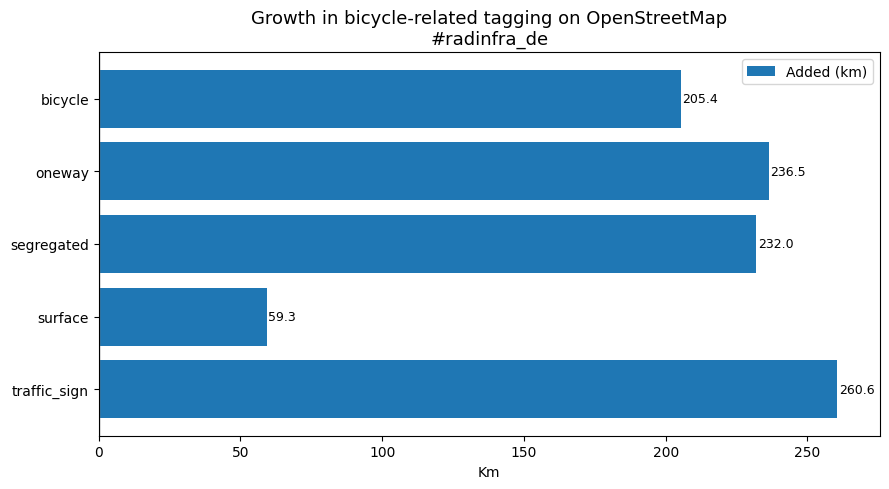

In [15]:
plt.figure(figsize=(9,5))

# reversed order
y = range(len(df))
added = df["km_added"][::-1]
deleted = df["km_deleted"][::-1]
cats = df["tag"][::-1]

plt.barh(y, added, label="Added (km)")
#plt.barh(y, -deleted, label="Deleted (km)")
plt.yticks(y, cats)

plt.xlabel("Km")

plt.title("Growth in bicycle-related tagging on OpenStreetMap\n#radinfra_de", fontsize=13)
plt.axvline(0, linewidth=1, color='gray')

# annotate values
for i, (a, d) in enumerate(zip(added, deleted)):
    plt.text(a + 0.5, i, f"{a:.1f}", va='center', ha='left', fontsize=9)
    #plt.text(-d - 0.5, i, f"{d:.1f}", va='center', ha='right', fontsize=9)

# --- add padding around data range ---
#min_val = deleted.max()
max_val = added.max()
#plt.xlim(-min_val -10, max_val +12)  # 15% padding on both sides
plt.xlim(0, max_val +15)  # 15% padding on both sides


plt.legend()
plt.tight_layout()
plt.show()

In [16]:
### nach Bundesland aufteilen

In [17]:
sql="""INSTALL spatial; LOAD spatial;

CREATE OR REPLACE TABLE bundeslaender AS
SELECT
  ST_GeomFromWKB(geometry) AS geom,
  tags['name'] AS name,
  tags['ISO3166-2'] AS iso,
  tags['wikidata'] AS wikidata
FROM read_parquet('~/ohsome-planet/out-germany_cs/contributions/latest/relation*-latest-contribs.parquet')
WHERE tags['boundary'] = 'administrative'
  AND tags['admin_level'] = '4';
"""

duckdb.sql(sql)

In [18]:
sql="""CREATE OR REPLACE TABLE tmp_rad2_with_state AS
SELECT
  t.*,
  b.name AS bundesland
FROM tmp_rad2 t
LEFT JOIN bundeslaender b
ON ST_Intersects(t.geom, b.geom)
WHERE t.osm_type='way'
  AND t.tags['highway'] IS NOT NULL;
"""

duckdb.sql(sql)

In [20]:
big_sql_string="""-- traffic_sign --------------------------------------------------------------
CREATE OR REPLACE TABLE traffic_sign_by_state AS
WITH base AS (
  SELECT
    COALESCE(bundesland,'Unknown')        AS bundesland,
    tags, tags_before,
    length                               AS len_after_m,
    length - COALESCE(length_delta, 0)   AS len_before_m,
    COALESCE(length_delta, 0)            AS dlen_m
  FROM tmp_rad2_with_state
  WHERE osm_type='way' AND tags['highway'] IS NOT NULL AND length IS NOT NULL
),
flags AS (
  SELECT
    bundesland, len_after_m, len_before_m, dlen_m,
    (tags['traffic_sign'] IS NOT NULL)          AS a_key,
    (tags_before['traffic_sign'] IS NOT NULL)   AS b_key
  FROM base
)
SELECT
  bundesland,
  ROUND( (SUM(CASE WHEN a_key AND NOT b_key THEN len_after_m ELSE 0 END)
        + SUM(CASE WHEN a_key AND     b_key THEN GREATEST(dlen_m,0) ELSE 0 END)) /1000.0, 1) AS km_added,
  ROUND( (SUM(CASE WHEN b_key AND NOT a_key THEN len_before_m ELSE 0 END)
        + SUM(CASE WHEN b_key AND     a_key THEN -LEAST(dlen_m,0) ELSE 0 END)) /1000.0, 1)   AS km_deleted
FROM flags
GROUP BY bundesland
ORDER BY km_added DESC, bundesland;

-- surface -------------------------------------------------------------------
CREATE OR REPLACE TABLE surface_by_state AS
WITH base AS (
  SELECT
    COALESCE(bundesland,'Unknown') AS bundesland, tags, tags_before,
    length AS len_after_m, length - COALESCE(length_delta, 0) AS len_before_m,
    COALESCE(length_delta, 0) AS dlen_m
  FROM tmp_rad2_with_state
  WHERE osm_type='way' AND tags['highway'] IS NOT NULL AND length IS NOT NULL
),
flags AS (
  SELECT
    bundesland, len_after_m, len_before_m, dlen_m,
    (tags['surface'] IS NOT NULL)        AS a_key,
    (tags_before['surface'] IS NOT NULL) AS b_key
  FROM base
)
SELECT
  bundesland,
  ROUND( (SUM(CASE WHEN a_key AND NOT b_key THEN len_after_m ELSE 0 END)
        + SUM(CASE WHEN a_key AND     b_key THEN GREATEST(dlen_m,0) ELSE 0 END)) /1000.0, 1) AS km_added,
  ROUND( (SUM(CASE WHEN b_key AND NOT a_key THEN len_before_m ELSE 0 END)
        + SUM(CASE WHEN b_key AND     a_key THEN -LEAST(dlen_m,0) ELSE 0 END)) /1000.0, 1)   AS km_deleted
FROM flags
GROUP BY bundesland
ORDER BY km_added DESC, bundesland;

-- segregated ----------------------------------------------------------------
CREATE OR REPLACE TABLE segregated_by_state AS
WITH base AS (
  SELECT
    COALESCE(bundesland,'Unknown') AS bundesland, tags, tags_before,
    length AS len_after_m, length - COALESCE(length_delta, 0) AS len_before_m,
    COALESCE(length_delta, 0) AS dlen_m
  FROM tmp_rad2_with_state
  WHERE osm_type='way' AND tags['highway'] IS NOT NULL AND length IS NOT NULL
),
flags AS (
  SELECT
    bundesland, len_after_m, len_before_m, dlen_m,
    (tags['segregated'] IS NOT NULL)          AS a_key,
    (tags_before['segregated'] IS NOT NULL)   AS b_key
  FROM base
)
SELECT
  bundesland,
  ROUND( (SUM(CASE WHEN a_key AND NOT b_key THEN len_after_m ELSE 0 END)
        + SUM(CASE WHEN a_key AND     b_key THEN GREATEST(dlen_m,0) ELSE 0 END)) /1000.0, 1) AS km_added,
  ROUND( (SUM(CASE WHEN b_key AND NOT a_key THEN len_before_m ELSE 0 END)
        + SUM(CASE WHEN b_key AND     a_key THEN -LEAST(dlen_m,0) ELSE 0 END)) /1000.0, 1)   AS km_deleted
FROM flags
GROUP BY bundesland
ORDER BY km_added DESC, bundesland;

-- bicycle -------------------------------------------------------------------
CREATE OR REPLACE TABLE bicycle_by_state AS
WITH base AS (
  SELECT
    COALESCE(bundesland,'Unknown') AS bundesland, tags, tags_before,
    length AS len_after_m, length - COALESCE(length_delta, 0) AS len_before_m,
    COALESCE(length_delta, 0) AS dlen_m
  FROM tmp_rad2_with_state
  WHERE osm_type='way' AND tags['highway'] IS NOT NULL AND length IS NOT NULL
),
flags AS (
  SELECT
    bundesland, len_after_m, len_before_m, dlen_m,
    (tags['bicycle'] IS NOT NULL)        AS a_key,
    (tags_before['bicycle'] IS NOT NULL) AS b_key
  FROM base
)
SELECT
  bundesland,
  ROUND( (SUM(CASE WHEN a_key AND NOT b_key THEN len_after_m ELSE 0 END)
        + SUM(CASE WHEN a_key AND     b_key THEN GREATEST(dlen_m,0) ELSE 0 END)) /1000.0, 1) AS km_added,
  ROUND( (SUM(CASE WHEN b_key AND NOT a_key THEN len_before_m ELSE 0 END)
        + SUM(CASE WHEN b_key AND     a_key THEN -LEAST(dlen_m,0) ELSE 0 END)) /1000.0, 1)   AS km_deleted
FROM flags
GROUP BY bundesland
ORDER BY km_added DESC, bundesland;

-- oneway --------------------------------------------------------------------
CREATE OR REPLACE TABLE oneway_by_state AS
WITH base AS (
  SELECT
    COALESCE(bundesland,'Unknown') AS bundesland, tags, tags_before,
    length AS len_after_m, length - COALESCE(length_delta, 0) AS len_before_m,
    COALESCE(length_delta, 0) AS dlen_m
  FROM tmp_rad2_with_state
  WHERE osm_type='way' AND tags['highway'] IS NOT NULL AND length IS NOT NULL
),
flags AS (
  SELECT
    bundesland, len_after_m, len_before_m, dlen_m,
    (tags['oneway'] IS NOT NULL)        AS a_key,
    (tags_before['oneway'] IS NOT NULL) AS b_key
  FROM base
)
SELECT
  bundesland,
  ROUND( (SUM(CASE WHEN a_key AND NOT b_key THEN len_after_m ELSE 0 END)
        + SUM(CASE WHEN a_key AND     b_key THEN GREATEST(dlen_m,0) ELSE 0 END)) /1000.0, 1) AS km_added,
  ROUND( (SUM(CASE WHEN b_key AND NOT a_key THEN len_before_m ELSE 0 END)
        + SUM(CASE WHEN b_key AND     a_key THEN -LEAST(dlen_m,0) ELSE 0 END)) /1000.0, 1)   AS km_deleted
FROM flags
GROUP BY bundesland
ORDER BY km_added DESC, bundesland;
"""

#duckdb.sql(sql)

In [21]:
# Schritt 1: Alle Tabellen erzeugen
duckdb.sql(big_sql_string)  # führt CREATE TABLE ... aus, gibt nichts zurück

# Schritt 2: Alle Ergebnisse in DataFrames holen
df_traffic = duckdb.sql("SELECT * FROM traffic_sign_by_state").df()
df_surface = duckdb.sql("SELECT * FROM surface_by_state").df()
df_segreg  = duckdb.sql("SELECT * FROM segregated_by_state").df()
df_bicycle = duckdb.sql("SELECT * FROM bicycle_by_state").df()
df_oneway  = duckdb.sql("SELECT * FROM oneway_by_state").df()

In [23]:
df_traffic

,bundesland,km_added,km_deleted
0,Baden-Württemberg,128.8,5.9
1,Bayern,124.9,6.4
2,Brandenburg,59.3,0.8
3,Niedersachsen,48.5,0.0
4,Nordrhein-Westfalen,45.2,0.0
5,Sachsen-Anhalt,32.9,0.2
6,Thüringen,15.3,2.6
7,Berlin,10.0,0.2
8,Hessen,4.4,0.1
9,Sachsen,4.0,0.0


In [24]:
df_segreg

,bundesland,km_added,km_deleted
0,Baden-Württemberg,125.8,12.3
1,Bayern,103.0,11.7
2,Nordrhein-Westfalen,33.9,1.0
3,Rheinland-Pfalz,27.9,0.1
4,Brandenburg,23.0,1.9
5,Unknown,20.2,0.0
6,Niedersachsen,18.2,1.8
7,Sachsen-Anhalt,14.8,1.1
8,Thüringen,10.2,0.4
9,Berlin,6.9,0.0


## helper

In [12]:
duckdb.sql("""
SELECT MAX(valid_from) AS max_valid_from
FROM read_parquet(
  ['/home/simon/ohsome-planet/out-berlin_cs/contributions/history/*-*-history-contribs.parquet',
   '/home/simon/ohsome-planet/out-berlin_cs/contributions/latest/*-*-latest-contribs.parquet'],
  union_by_name = true
);
""").show()

┌──────────────────────────┐
│      max_valid_from      │
│ timestamp with time zone │
├──────────────────────────┤
│ 2025-10-06 01:57:52+02   │
└──────────────────────────┘



In [20]:
import duckdb
duckdb.sql("""
DESCRIBE SELECT * 
FROM read_parquet('/home/simon/ohsome-planet/out-berlin_cs/contributions/history/way-*-history-contribs.parquet')
""").df()


,column_name,column_type,null,key,default,extra
0,status,VARCHAR,YES,None,None,None
1,valid_from,TIMESTAMP WITH TIME ZONE,YES,None,None,None
2,valid_to,TIMESTAMP WITH TIME ZONE,YES,None,None,None
3,osm_type,VARCHAR,YES,None,None,None
4,osm_id,BIGINT,YES,None,None,None
5,osm_version,INTEGER,YES,None,None,None
6,osm_minor_version,INTEGER,YES,None,None,None
7,osm_edits,INTEGER,YES,None,None,None
8,osm_last_edit,TIMESTAMP WITH TIME ZONE,YES,None,None,None
9,user,"STRUCT(id INTEGER, ""name"" VARCHAR)",YES,None,None,None
